Team Name : PeErEx

Team Leader : Bayu Wicaksono

Team Member : 
1. Mochamad Khaairi
2. Muhammad Fikri Kafilli

## **Overview**

This project involves classifying images of T-shirts and hoodies from various online stores in Indonesia into categories based on type and color.

## **Dataset**
The dataset comprises 1111 images split into training and test sets:

### **Training Set:**
- **train**: Contains 777 images of T-shirts and hoodies in 5 different colors.
- **train.csv**: CSV file containing labels for each training image.
  - **id**: Unique ID for each training image.
  - **jenis**: Type of clothing (0: T-shirt, 1: Hoodie).
  - **warna**: Color of clothing (0: Red, 1: Yellow, 2: Blue, 3: Black, 4: White).

### **Test Set:**
- **test**: Contains 334 images for classification.

## Requirement
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 pandas numpy matplotlib seaborn opencv-python Pillow transformers scikit-learn

## Import Library

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split

## EDA and Data Preprocessing

### Load Data

We begin by loading the training data from the specified directory and reading the accompanying CSV file containing labels. This sets up our environment for further data processing.

In [4]:
# Image Directory
data_image = 'hology/data/train/train'

# Load CSV file
data = pd.read_csv('hology/data/train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      777 non-null    int64
 1   jenis   777 non-null    int64
 2   warna   777 non-null    int64
dtypes: int64(3)
memory usage: 18.3 KB


### Check for Duplicate Data

Next, we preprocess the images to check for any duplicates. We need to load every images and then save it as pixels value, so we can compare it. The process includes, each image is read using cv2 library, and then because cv2 read images in BGR (blue, green, red) colors, we need to converted to RGB, do resized, flattened into a 1D array, and save pixels value along with its id into dataframe. This transformation allows us to compare images efficiently.

In [5]:
image_data = []
image_ids = []

# extract id and pixel from image to dataframe
for img_file in os.listdir(data_image):
    img_path = os.path.join(data_image, img_file)

    if os.path.isfile(img_path):
        # get image id from file name
        img_id = np.int64(os.path.splitext(img_file)[0])

        # load image with BGR color
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)

        if image is not None:
            # convert from BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # resize image
            image = cv2.resize(image, (244, 244))

            # flatten image to 1D array and convert to string
            image_flat = ' '.join(map(str, image.flatten()))

            # save pixel and image id
            image_data.append(image_flat)
            image_ids.append(img_id)

df = pd.DataFrame({
    'id': image_ids,
    'pixels': image_data
})

df.head()

,id,pixels
0,1,242 242 242 242 242 242 242 242 242 242 242 24...
1,10,255 255 255 255 255 255 255 255 255 255 255 25...
2,100,250 250 250 250 250 250 250 250 250 250 250 25...
3,101,255 255 255 255 255 255 255 255 255 255 255 25...
4,102,153 104 45 151 103 41 149 101 38 148 100 35 14...


We then check for any duplicate images based on their pixel values. This ensures the uniqueness of the images used in our training and evaluation processes. Subset is used to ensure that duplicate checking is only performed for pixel values

In [6]:
duplicate_count = df.duplicated(subset='pixels').sum()

print(f"Number of duplicate rows': {duplicate_count}")

Number of duplicate rows': 5


In [7]:
df[df.duplicated(subset='pixels')]

,id,pixels
412,470,255 255 255 255 255 255 255 255 255 255 255 25...
570,612,220 218 219 220 218 219 220 218 219 220 218 21...
674,706,255 255 255 255 255 255 255 255 255 255 255 25...
725,752,255 255 255 255 255 255 255 255 255 255 255 25...
738,764,255 255 255 255 255 255 255 255 255 255 255 25...


We store duplicate IDs in a list. This list will later be used to filter out and delete duplicate rows from the dataframe, ensuring the dataset contains only unique images.

In [8]:
id_duplicate = df[df.duplicated(subset='pixels')]['id'].tolist()

### Clothing Type Data Distribution

We map the numerical labels for clothing types to their corresponding string labels (0: Kaos, 1: Hoodie). We then calculate the count of each type and create a dataframe to store these counts.

In [9]:
labels = {0:'Kaos', 1:'Hoodie'}
counts = data['jenis'].value_counts(sort=True).reset_index()
counts.columns = ['jenis', 'number']
counts['jenis'] = counts['jenis'].map(labels)
counts

,jenis,number
0,Kaos,476
1,Hoodie,301


To understand the distribution of different categories in our dataset, we create a bar plot. The plot displays the count of each category (T-shirt and Hoodie), which helps in visualizing how balanced the dataset is.

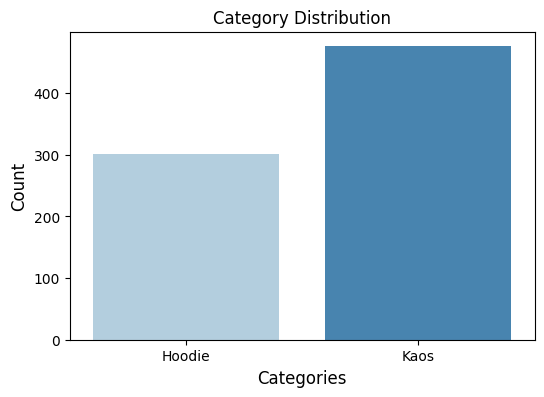

In [10]:
counts_sorted = counts.sort_values(by='number', ascending=True)
colors = sns.color_palette("Blues", len(counts_sorted))

plt.figure(figsize=(6, 4))
sns.barplot(x=counts_sorted.jenis, y=counts_sorted.number, palette=colors, hue=counts_sorted.jenis)
plt.title('Category Distribution')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Categories', fontsize=12)
plt.show()

### Clothing Color Data Distribution

For color labels, we do the same thing as we did for clothing type

In [11]:
labels = {0:'merah', 1:'kuning', 2:'biru', 3:'hitam', 4:'putih'}
counts = data['warna'].value_counts(sort=True).reset_index()
counts.columns = ['warna', 'number']
counts['warna'] = counts['warna'].map(labels)
counts

,warna,number
0,hitam,234
1,biru,162
2,putih,140
3,kuning,125
4,merah,116


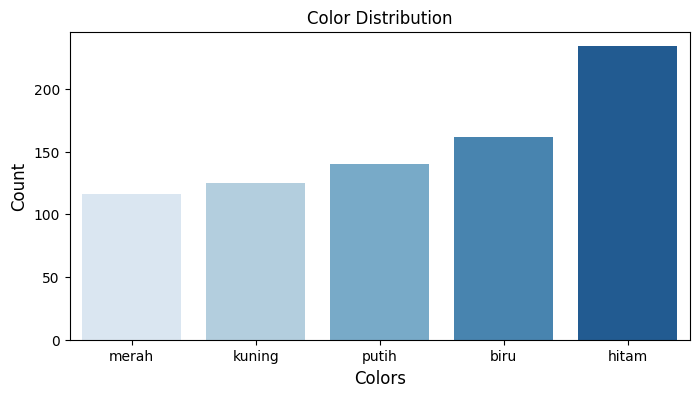

In [12]:
counts_sorted = counts.sort_values(by='number', ascending=True)

colors = sns.color_palette("Blues", len(counts_sorted))

plt.figure(figsize=(8, 4))
sns.barplot(x=counts_sorted.warna, y=counts_sorted.number, palette=colors, hue=counts_sorted.warna)
plt.title('Color Distribution')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Colors', fontsize=12)
plt.show()

### Data Training Preparation

We define a function to locate the image file based on its ID. This helps in dynamically finding the correct image file in the specified directory.

In [13]:
# find image path based image id
def find_file_path(img_dir, img_id):
    for ext in ['jpg', 'png', 'jpeg']:
        file_path = os.path.join(img_dir, f'{img_id}.{ext}')
        if os.path.exists(file_path):
            return file_path.replace('\\', '/')
    return None

We create a custom dataset class using PyTorch. This class handles the loading of image data and corresponding labels, as well as applying any required transformations to the images.

In [14]:
class ClothingDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        # delete duplicate data
        # self.data = self.data[~self.data['id'].isin(id_duplicate)].reset_index(drop=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get id from csv file
        img_id = str(self.data.iloc[idx, 0])
        # get image path
        img_path = find_file_path(self.img_dir, img_id)

        # Periksa apakah file ada
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Gambar {img_path} tidak ditemukan.")

        # convert image to RGB
        image = Image.open(img_path).convert("RGB")

        # get label data from csv file
        jenis = torch.tensor(self.data.iloc[idx, 1], dtype=torch.long)
        warna = torch.tensor(self.data.iloc[idx, 2], dtype=torch.long)

        # apply transformation to image
        if self.transform:
            image = self.transform(image)

        return image, jenis, warna

We defines a transformation pipeline for image processing using PyTorch's transforms module, including resized images into 224x224 pixels to macth with input size of model. Then we load the training data, and split it into training and validation sets. We use data loaders to facilitate efficient batching and shuffling during training.

In [15]:
# define transformation for image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# load data training
full_train_dataset = ClothingDataset(csv_file="hology/data/train.csv", img_dir="hology/data/train/train", transform=transform)

# set seed
torch.manual_seed(42)

# determine data training and validation sizes (80% and 20%)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# set seed
generator = torch.Generator().manual_seed(42)

# split dataset
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size], generator=generator)

# create DataLoader for data training and validation
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

## Model Development

We define a custom neural network using the Vision Transformer (ViT) model from the Transformers library by Hugging Face. The model is fine-tuned for multi-label classification to predict both the type of clothing and its color.

- We load a pre-trained ViT model (`vit-base-patch16-224`) and create two custom classification heads.
- `vit-base-patch16-224` is specific ViT model with the input image is divided into patches of 16x16 pixels and resolution of the input image, specifically 224x224 pixels.
- The `classifier_jenis` head is for binary classification of clothing type (T-shirt or Hoodie).
- The `classifier_warna` head is for multi-class classification of clothing color (5 colors).

In [16]:
from transformers import ViTModel
import torch.nn as nn

class MultiLabelViT(nn.Module):
    def __init__(self, pretrained_model_name='google/vit-base-patch16-224'):
        super(MultiLabelViT, self).__init__()
        # load pre-trained model
        self.vit = ViTModel.from_pretrained(pretrained_model_name)

        # get the size (dimension) of the hidden layer representation
        hidden_size = self.vit.config.hidden_size

        # define custom classification heads
        self.classifier_jenis = nn.Linear(hidden_size, 1) # for clothing type, binary classification
        self.classifier_warna = nn.Linear(hidden_size, 5) # for clothing color, multi-class classification

    def forward(self, pixel_values):
        # process the input image through the ViT model and get the output
        outputs = self.vit(pixel_values=pixel_values)

        # taking the output from the last hidden layer
        last_hidden_state = outputs.last_hidden_state

        # get representation of classification token ([CLS])
        cls_token = last_hidden_state[:, 0, :]

        # generate logits for each label
        jenis_logits = self.classifier_jenis(cls_token)
        warna_logits = self.classifier_warna(cls_token)

        return jenis_logits, warna_logits


# init model
model = MultiLabelViT()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

c:\Users\User\Documents\Code\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MultiLabelViT(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, 

We calculate the total number of parameters and the number of trainable parameters in the model. This provides insights into the complexity of the model and the training process.

In [17]:
# see the number of parameters to be updated
num_params = sum([p.numel() for p in model.parameters()])
trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])

print(f"{num_params = :,} | {trainable_params = :,}")

num_params = 86,393,862 | trainable_params = 86,393,862


### Evaluation Model Process

We define a function to evaluate the performance of our model. The function calculates several metrics including accuracy and exact match ratio, and uses the precision-recall curve to determine the optimal threshold for binary classification.

- **Accuracy**: Measures how often the model correctly predicts the clothing type and color.
- **Exact Match Ratio**: The percentage of samples where both clothing type and color are predicted correctly.
- **Precision-Recall Curve**: Helps determine the optimal threshold for binary classification of clothing

In [18]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# evaluation model using accuracy and exact match ratio
def evaluate_model(model, dataloader):
    model.eval()
    total_samples = 0
    exact_match_count = 0
    correct_jenis = 0
    correct_warna = 0
    all_true_labels = []
    all_predicted_probs = []

    with torch.no_grad():
        for images, jenis, warna in dataloader:
            images = images.to(device)
            jenis = jenis.to(device).float().view(-1)
            warna = warna.to(device)

            # forward pass
            jenis_logits, warna_logits = model(images)

            # apply sigmoid to convert logits to probabilities for binary classification
            predicted_jenis = torch.sigmoid(jenis_logits)

            # store predicted probabilities and true labels for ROC-AUC calculation
            all_predicted_probs.extend(predicted_jenis.cpu().numpy())
            all_true_labels.extend(jenis.cpu().numpy())

            # apply threshold of 0.5
            predicted_jenis = (predicted_jenis > 0.5).long().view(-1)


            # prediction for multi-class classification
            _, predicted_warna = torch.max(warna_logits, 1)

            # calculate accuracy for each label
            correct_jenis += (predicted_jenis == jenis.long()).sum().item()
            correct_warna += (predicted_warna == warna).sum().item()

            # calculate exact match ratio
            exact_match_count += ((predicted_jenis == jenis.long()) & (predicted_warna == warna)).sum().item()
            total_samples += jenis.size(0)

    # calculate all evaluation matrix
    jenis_accuracy = correct_jenis / total_samples * 100
    warna_accuracy = correct_warna / total_samples * 100
    exact_match_ratio = exact_match_count / total_samples * 100

    # calculate precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(all_true_labels, all_predicted_probs)

    # calculate optimal threshold
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-7)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    print(f'Optimal Threshold: {optimal_threshold:.4f}')
    print(f'Akurasi Jenis: {jenis_accuracy:.2f}%, Akurasi Warna: {warna_accuracy:.2f}%, Exact Match Ratio (EMR): {exact_match_ratio:.2f}%')


### Training Model Process

We define the loss functions and optimizer for our multi-label classification model. The training loop iterates through the dataset, computes losses for both labels, and updates the model parameters to minimize the combined loss. An additional penalty for the exact match ratio (EMR) ensures the model is penalized for incorrect predictions.

- **Loss Functions**:
  - `lossFunc_jenis`: Binary Cross-Entropy Loss for clothing type.
  - `lossFunc_warna`: Cross-Entropy Loss for clothing color.
- **Optimizer**: Adam optimizer with a learning rate of 1e-4.
- **Alpha**: Penalty weight for EMR to ensure correct multi-label predictions.

In [19]:
import torch.nn.functional as F
import torch.optim as optim

# define training arguments
lossFunc_jenis = nn.BCEWithLogitsLoss()  # binary loss for 'jenis'
lossFunc_warna = nn.CrossEntropyLoss()  # multi-class loss for 'warna'
alpha = 0.1  # penalty weight for EMR
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss_epoch = 0

    for images, jenis, warna in train_loader:
        images, jenis, warna = images.to(device), jenis.to(device).float(), warna.to(device).float()

        optimizer.zero_grad()

        # forward pass
        jenis_logits, warna_logits = model(images)

        # compute the losses for each label
        loss_jenis = lossFunc_jenis(jenis_logits, jenis.unsqueeze(1))
        loss_warna = lossFunc_warna(warna_logits, warna.long())

        # custom loss for exact match
        _, predicted_jenis = torch.max(jenis_logits, dim=1)
        _, predicted_warna = torch.max(warna_logits, dim=1)
        correct_predictions = (predicted_jenis == jenis) & (predicted_warna == warna)
        penalti_EMR = (1 - correct_predictions.float()).mean()

        # combine losses
        total_loss = loss_jenis + loss_warna + alpha * penalti_EMR
        
        # backward pass
        total_loss.backward()
        optimizer.step()

        total_loss_epoch += total_loss.item()

    avg_loss = total_loss_epoch / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")

    # evaluate model
    evaluate_model(model, val_loader)


c:\Users\User\Documents\Code\env\lib\site-packages\transformers\models\vit\modeling_vit.py:261: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(


Epoch [1/10], Loss: 0.733513
Optimal Threshold: 0.6390
Akurasi Jenis: 98.72%, Akurasi Warna: 97.44%, Exact Match Ratio (EMR): 96.15%
Epoch [2/10], Loss: 0.104613
Optimal Threshold: 0.5454
Akurasi Jenis: 100.00%, Akurasi Warna: 98.72%, Exact Match Ratio (EMR): 98.72%
Epoch [3/10], Loss: 0.061821
Optimal Threshold: 0.6511
Akurasi Jenis: 100.00%, Akurasi Warna: 98.08%, Exact Match Ratio (EMR): 98.08%
Epoch [4/10], Loss: 0.048526
Optimal Threshold: 0.2465
Akurasi Jenis: 99.36%, Akurasi Warna: 100.00%, Exact Match Ratio (EMR): 99.36%
Epoch [5/10], Loss: 0.044127
Optimal Threshold: 0.3535
Akurasi Jenis: 99.36%, Akurasi Warna: 100.00%, Exact Match Ratio (EMR): 99.36%
Epoch [6/10], Loss: 0.042815
Optimal Threshold: 0.3327
Akurasi Jenis: 99.36%, Akurasi Warna: 100.00%, Exact Match Ratio (EMR): 99.36%
Epoch [7/10], Loss: 0.042093
Optimal Threshold: 0.3221
Akurasi Jenis: 99.36%, Akurasi Warna: 100.00%, Exact Match Ratio (EMR): 99.36%
Epoch [8/10], Loss: 0.041657
Optimal Threshold: 0.3037
Akurasi 

### Save Model

In [24]:
# torch.save(model.state_dict(), "hology/model/multilabel_vit-1.pth")

## Inference Process

In [25]:
# # Load the model
# model = MultiLabelViT()
# model.load_state_dict(torch.load("hology/model/multilabel_vit-1.pth", map_location=device))
# model.to(device)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\User\AppData\Local\Temp\ipykernel_11040\84290560.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializat

MultiLabelViT(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, 

We define function to predict data test by generates a CSV file for save result of prediction later. This function begins by listing all files within the img_dir directory and extracts the image IDs by removing the file extensions from each filename. It then creates a DataFrame.

In [26]:
# create csv file for test data
def create_test_csv(img_dir, output_csv):
    # list all files in the test directory
    img_files = os.listdir(img_dir)

    # extract id from filename
    img_ids = [os.path.splitext(f)[0] for f in img_files]

    # create dataframe for test data with column jenis and warna is fill with null values
    df = pd.DataFrame({
        'id': img_ids,
        'jenis': -1,
        'warna': -1
    })
    df = df.sort_values(by='id', ascending=True)
    # save dataframe to csv
    df.to_csv(output_csv, index=False)

# Create the CSV file for test data
create_test_csv('hology/data/test/test', 'hology/data/test_predictions.csv')

This function loads a trained model to predict labels for a test dataset. It reads images and their IDs from a specified directory and loads them using a custom ClothingDataset class. The function prepares batches of test data, runs them through the model in evaluation mode, and generates predictions for both jenis and warna attributes. For binary classification (jenis), it applies a threshold to sigmoid outputs, and for multi-class color classification (warna), it selects the class with the highest logit. The predictions are then stored and used to update the test CSV file, which is saved with sorted entries by ID.

In [27]:
def predict_and_save(model, test_csv, img_dir, output_csv, transform, batch_size=16, threshold=0.5):
    # Load test dataset and create dataloader
    test_dataset = ClothingDataset(csv_file=test_csv, img_dir=img_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model.eval()
    predictions = []

    with torch.no_grad():
        for images, _, _ in test_loader:
            images = images.to(device)

            # get predictions
            jenis_logits, warna_logits = model(images)

            # predict for jenis label
            predicted_jenis = torch.sigmoid(jenis_logits)
            predicted_jenis = (predicted_jenis > threshold).long()  # Apply optimal threshold values
            
            # predict for warna label
            _, predicted_warna = torch.max(warna_logits, 1)

            # store predictions
            for jenis, warna in zip(predicted_jenis.cpu().numpy(), predicted_warna.cpu().numpy()):
                predictions.append((int(jenis), int(warna)))

    # load test CSV and update jenis and warna column with predictions
    df = pd.read_csv(test_csv)
    df['jenis'] = [p[0] for p in predictions]
    df['warna'] = [p[1] for p in predictions]

    # save csv
    df = df.sort_values(by='id', ascending=True)
    df.to_csv(output_csv, index=False)
    print(f"Predictions saved to {output_csv}")


# Run prediction and save the results
opt_threshold = 0.7
predict_and_save(model,
                 test_csv='hology/data/test_predictions.csv',
                 img_dir='hology/data/test/test',
                 output_csv='hology/data/test_predictions.csv',
                 transform=transform, threshold=opt_threshold)


C:\Users\User\AppData\Local\Temp\ipykernel_11040\3280458754.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predictions.append((int(jenis), int(warna)))


Predictions saved to test_predictions.csv
